In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Math, Latex
from matplotlib import pyplot as plt
import re
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import IsolationForest
from catboost import CatBoostRegressor


In [2]:
# 0. МЕТРИКА
def calculate_iou(lower_true, upper_true, lower_pred, upper_pred, epsilon=1e-6):
    intersection = np.maximum(0, np.minimum(upper_true, upper_pred) - np.maximum(lower_true, lower_pred))
    union = (upper_true - lower_true + epsilon) + (upper_pred - lower_pred + epsilon) - intersection
    return np.mean(intersection / union)

# 1. ЗАГРУЗКА
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train['dt'] = pd.to_datetime(train['dt'])
test['dt'] = pd.to_datetime(test['dt'])

# 2. ЦИКЛИЧЕСКИЕ ПРИЗНАКИ
def add_cyclical_features(df):
    df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)
    return df

train = add_cyclical_features(train)
test = add_cyclical_features(test)

# 3. ПОДГОТОВКА КАТЕГОРИЙ И ПРИЗНАКОВ
cat_features = [
    'management_group_id', 'first_category_id', 'second_category_id', 
    'third_category_id', 'product_id', 'holiday_flag', 'activity_flag'
]
features = [
    'n_stores', 'precpt', 'avg_temperature', 'avg_humidity', 
    'avg_wind_level', 'week_of_year',
    'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos'
] + cat_features

for col in cat_features:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)

# --- БЛОК: ДЕТЕКЦИЯ АНОМАЛИЙ (sklearn) ---
print("Удаление аномалий...")
iso_features = ['price_p05', 'price_p95', 'avg_temperature', 'product_id']
iso_data = train[iso_features].fillna(0)

# Ищем 1% выбросов
iso_forest = IsolationForest(n_estimators=300, contamination=0.03, random_state=42, n_jobs=-1)
train['is_anomaly'] = iso_forest.fit_predict(iso_data)

# Оставляем только нормальные записи (1 - норма, -1 - аномалия)
train_cleaned = train[train['is_anomaly'] == 1].copy()
print(f"Удалено аномалий: {len(train) - len(train_cleaned)}")

Удаление аномалий...
Удалено аномалий: 873


In [3]:
train['is_anomaly'].value_counts()

is_anomaly
 1    28227
-1      873
Name: count, dtype: int64

In [4]:
# 4. ВАЛИДАЦИЯ
max_train_date = train_cleaned['dt'].max()
val_start_date = max_train_date - pd.Timedelta(days=4)

train_part = train_cleaned[train_cleaned['dt'] < val_start_date]
val_part = train_cleaned[train_cleaned['dt'] >= val_start_date]

cb_params = {
    'iterations': 2000,            # Увеличили запас
    'learning_rate': 0.05,          # Снизили шаг для точности
    'depth': 6,
    'loss_function': 'MAE', 
    'random_seed': 42,
    'verbose': 100,
    'early_stopping_rounds': 100    # Если 100 шагов нет прогресса — стоп
}

print("Обучение валидационных моделей...")
model_low_val = CatBoostRegressor(**cb_params)
model_high_val = CatBoostRegressor(**cb_params)

print("Обучение валидационных моделей с поиском лучшей итерации...")

model_low_val.fit(
    train_part[features], train_part['price_p05'],
    eval_set=(val_part[features], val_part['price_p05']), # Следим за качеством тут
    cat_features=cat_features,
    use_best_model=True                                   # Откатимся к лучшим весам
)

model_high_val.fit(
    train_part[features], train_part['price_p95'],
    eval_set=(val_part[features], val_part['price_p95']),
    cat_features=cat_features,
    use_best_model=True
)

p_low_val = model_low_val.predict(val_part[features])
p_high_val = model_high_val.predict(val_part[features])
val_score = calculate_iou(val_part['price_p05'], val_part['price_p95'], p_low_val, p_high_val)
print(f"\nВалидационный IoU: {val_score:.4f}")

# 5. ФИНАЛЬНОЕ ОБУЧЕНИЕ
print(f"Финальное обучение (итераций Low: {model_low_val.get_best_iteration()}, High: {model_high_val.get_best_iteration()})...")

# Создаем новые модели с фиксированным числом итераций
final_model_low = CatBoostRegressor(
    **{**cb_params, 'iterations': model_low_val.get_best_iteration() + 1}
)
final_model_high = CatBoostRegressor(
    **{**cb_params, 'iterations': model_high_val.get_best_iteration() + 1}
)

final_model_low.fit(train_cleaned[features], train_cleaned['price_p05'], cat_features=cat_features)
final_model_high.fit(train_cleaned[features], train_cleaned['price_p95'], cat_features=cat_features)

# 6. ПРЕДСКАЗАНИЕ
print("Создание предсказаний...")
test['price_p05'] = final_model_low.predict(test[features])
test['price_p95'] = final_model_high.predict(test[features])
test['price_p95'] = np.maximum(test['price_p95'], test['price_p05'] + 0.001)

# 7. СОХРАНЕНИЕ
submission = test[['row_id', 'price_p05', 'price_p95']].sort_values('row_id')
submission.to_csv('submission_iso_forest.csv', index=False)
print("Готово! Файл submission_iso_forest.csv сохранен.")

Обучение валидационных моделей...
Обучение валидационных моделей с поиском лучшей итерации...
0:	learn: 0.1217643	test: 0.1253794	best: 0.1253794 (0)	total: 160ms	remaining: 5m 20s
100:	learn: 0.0725450	test: 0.0759656	best: 0.0759656 (100)	total: 2.59s	remaining: 48.7s
200:	learn: 0.0699452	test: 0.0741553	best: 0.0741553 (200)	total: 5.37s	remaining: 48.1s
300:	learn: 0.0674217	test: 0.0724917	best: 0.0724917 (300)	total: 8.02s	remaining: 45.3s
400:	learn: 0.0658712	test: 0.0718104	best: 0.0718067 (399)	total: 10.5s	remaining: 41.9s
500:	learn: 0.0644851	test: 0.0709841	best: 0.0709841 (500)	total: 13.1s	remaining: 39.2s
600:	learn: 0.0633721	test: 0.0704886	best: 0.0704886 (600)	total: 15.7s	remaining: 36.5s
700:	learn: 0.0625565	test: 0.0702989	best: 0.0702989 (700)	total: 18.1s	remaining: 33.6s
800:	learn: 0.0618166	test: 0.0701225	best: 0.0700899 (788)	total: 20.6s	remaining: 30.9s
900:	learn: 0.0610341	test: 0.0698544	best: 0.0698224 (898)	total: 23.2s	remaining: 28.3s
1000:	lea

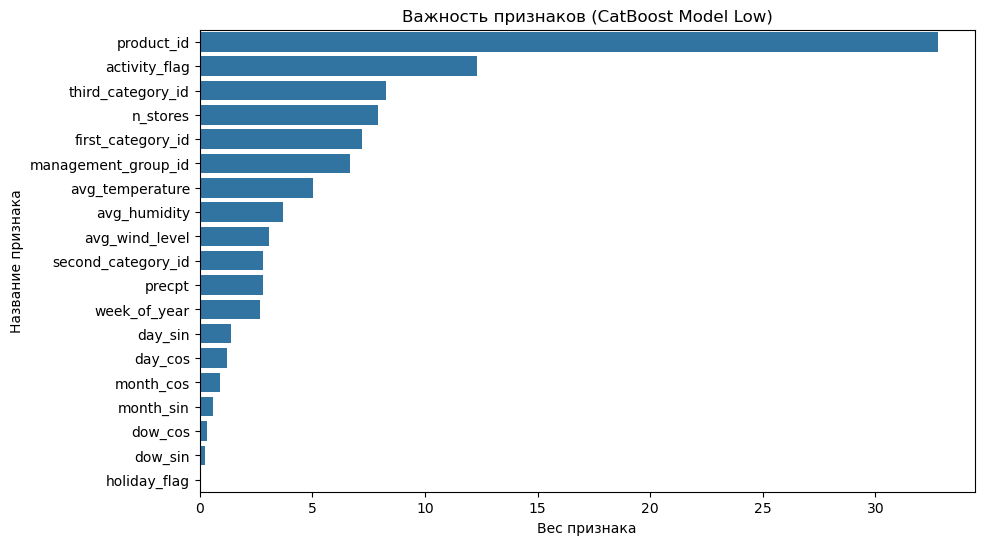

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем данные
feature_importance = model_low_val.get_feature_importance(prettified=True)

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance)
plt.title('Важность признаков (CatBoost Model Low)')
plt.xlabel('Вес признака')
plt.ylabel('Название признака')
plt.show()